<a href="https://colab.research.google.com/github/samaco634/deep-learning-basics/blob/main/02_%EA%BD%83_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_%EC%98%88%EC%A0%9C%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%82%AC%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 튜토리얼은 꽃 이미지를 분류하는 방법을 보여줍니다. `tf.keras.Sequential` 모델을 사용하여 이미지 분류자를 생성하고 `tf.keras.utils.image_dataset_from_directory`를 사용하여 데이터를 로드합니다. 다음 개념에 대한 실질적인 경험을 얻을 수 있을 겁니다.

- 디스크에서 데이터세트를 효율적으로 로드합니다.
- 데이터 증강 및 드롭아웃을 포함하여 과대적합을 식별하고 이를 완화하는 기술을 적용합니다.

이 튜토리얼은 기본적인 머신러닝 워크플로를 따릅니다.

1. 학습 데이터 모으기
2. 입력 파이프라인 빌드하기
3. 모델 빌드하기
4. 모델 훈련하기
5. 모델 테스트하기
6. 모델을 개선하고 프로세스 반복하기

## TensorFlow 및 기타 라이브러리 가져오기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 학습 데이터 모으기

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True, cache_dir='/content')
root = pathlib.Path(data_dir)

다운로드 후, 데이터세트 사본을 사용할 수 있습니다. 총 이미지의 개수를 알아 봅시다.

In [ ]:
image_count = len(list(root.glob('*/*.jpg')))
print(image_count)

3670


장미의 경우는 다음과 같습니다.

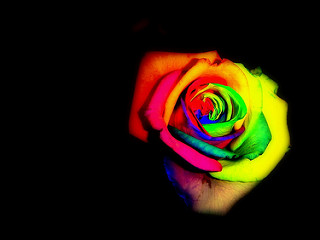

In [ ]:
roses = list(root.glob('roses/*'))
PIL.Image.open(str(roses[0]))

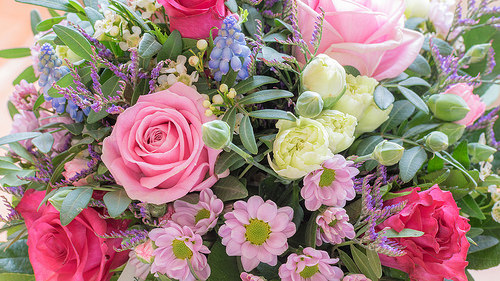

In [ ]:
PIL.Image.open(str(roses[1]))

튤립 그림도 확인해봅시다.

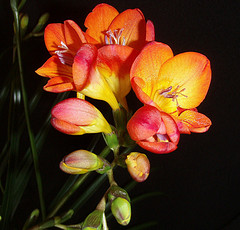

In [ ]:
tulips = list(root.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

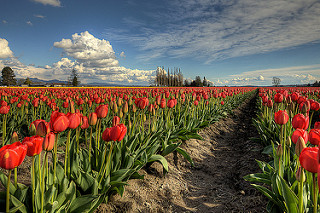

In [ ]:
PIL.Image.open(str(tulips[1]))

# Keras 유틸리티를 사용하여 데이터 로드하기

유용한 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 디스크에서 이러한 이미지를 로드해 보겠습니다. 이러면 몇 줄의 코드로 디스크의 이미지 디렉터리에서 `tf.data.Dataset`로 이동하게 됩니다. 

## 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 유효성 검사에 사용합니다.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 class_names 속성에서 클래스 이름을 찾을 수 있습니다.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


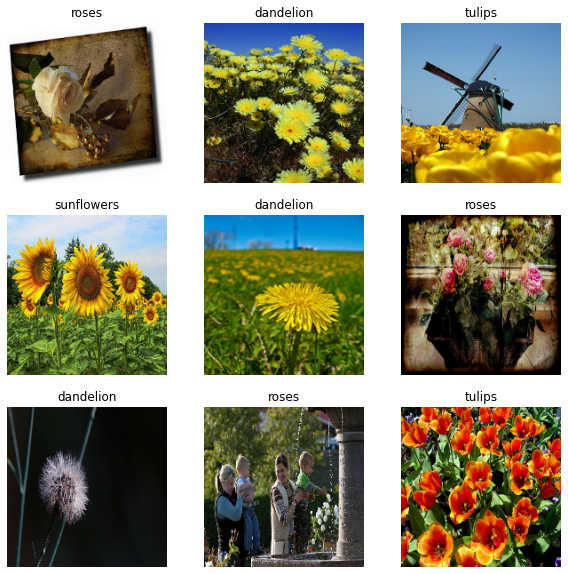

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터세트를 사용하는 모델을 model.fit(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch는 (32, 180, 180, 3) 형상의 텐서이며, 180x180x3 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). label_batch는 형상 (32,)의 텐서이며 32개 이미지에 해당하는 레이블입니다.

참고: 이들 텐서 중 하나에서 .numpy()를 호출하여 numpy.ndarray로 변환할 수 있습니다.

### 데이터 표준화하기
RGB 채널 값은 [0, 255] 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 tf.keras.layers.experimental.preprocessing.Rescaling 레이어를 사용하여 [0, 1] 범위에 있도록 값을 표준화합니다.

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근법을 사용할 것입니다.

참고: 픽셀 값을 [-1,1]으로 조정하려면 대신 Rescaling(1./127.5, offset=-1)를 작성할 수 있습니다.

참고: 이전에 tf.keras.preprocessing.image_dataset_from_directory의 image_size 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 tf.keras.layers.experimental.preprocessing.Resizing 레이어를 대신 사용할 수 있습니다.

### 성능을 위한 데이터세트 구성하기
버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

.cache()는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

.prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 훈련하기
완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 

# 모델 만들기

[순차](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 3개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 높은 정확도를 위해 조정되지 않았습니다. 이 튜토리얼의 목표는 표준 접근 방식을 보여주는 것입니다.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일하기

이 튜토리얼에서는 `tf.keras.optimizers.Adam` 옵티마이저와 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달합니다.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## 모델 요약

모델의 `Model.summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0

## 모델 훈련하기

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 10s 73ms/step - loss: 1.4825 - accuracy: 0.4036 - val_loss: 1.0752 - val_accuracy: 0.5995
Epoch 2/10
92/92 [==============================] - 2s 26ms/step - loss: 0.9884 - accuracy: 0.6165 - val_loss: 0.9580 - val_accuracy: 0.6390
Epoch 3/10
92/92 [==============================] - 2s 26ms/step - loss: 0.7085 - accuracy: 0.7503 - val_loss: 1.0152 - val_accuracy: 0.6035
Epoch 4/10
92/92 [==============================] - 3s 28ms/step - loss: 0.4157 - accuracy: 0.8566 - val_loss: 1.3898 - val_accuracy: 0.5627
Epoch 5/10
92/92 [==============================] - 3s 28ms/step - loss: 0.2615 - accuracy: 0.9169 - val_loss: 1.7230 - val_accuracy: 0.5300
Epoch 6/10
92/92 [==============================] - 2s 22ms/step - loss: 0.1957 - accuracy: 0.9380 - val_loss: 1.4293 - val_accuracy: 0.5695
Epoch 7/10
92/92 [==============================] - 2s 21ms/step - loss: 0.1314 - accuracy: 0.9588 - val_loss: 1.6455 - val_accuracy: 0.5804
Epoch 8/10
9

## 훈련 결과 시각화하기

훈련 및 검증 세트에 대한 손실 및 정확도 플롯을 생성합니다.

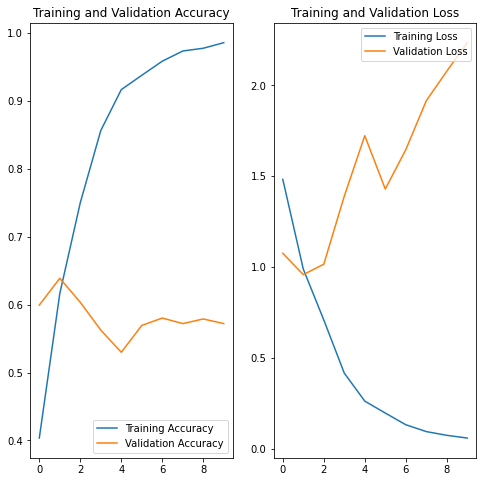

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

플롯은 훈련 정확도와 검증 정확도가 큰 차이로 떨어져 있으며 모델은 검증 세트에서 약 60%의 정확도만을 달성했음을 보여줍니다.

무엇이 잘못되었는지 살펴보고 모델의 전반적인 성능을 향상시키도록 하겠습니다.

1/1 [==============================] - 0s 16ms/step


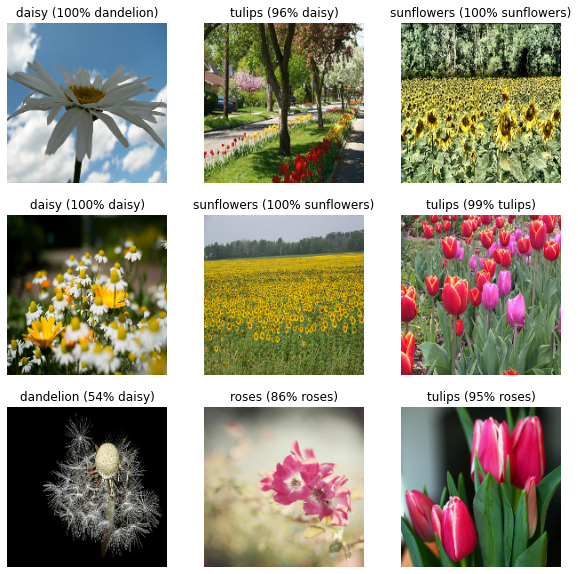

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predictions = model.predict(tf.expand_dims(images[i], 0))
    score = tf.nn.softmax(predictions[0])

    plt.title("{} ({:2.0f}% {})".format(class_names[labels[i]],
                                100*np.max(score),
                                class_names[np.argmax(score)]))
    plt.axis("off")

## 과대적합

위의 플롯에서 훈련 정확성은 시간이 지남에 따라 선형적으로 증가하는 반면, 검증 정확성은 훈련 과정에서 약 80%를 벗어나지 못합니다. 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당한데, 이는 [과대적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)의 징후입니다.

훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미치는 정도까지 훈련 예제의 노이즈나 원치 않는 세부까지 학습합니다. 이 현상을 과대적합이라고 합니다. 이는 모델이 새 데이터세트에서 일반화하는 데 어려움이 있음을 의미합니다.

훈련 과정에서 과대적합을 막는 여러 가지 방법들이 있습니다. 이 튜토리얼에서는 *데이터 증강*을 사용하고 모델에 *드롭아웃*을 추가합니다.

## 데이터 증강

과대적합은 일반적으로 훈련 예제가 적을 때 발생합니다. [데이터 증강](./data_augmentation.ipynb)은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다. 그러면 모델이 데이터의 더 많은 측면을 파악하게 되므로 일반화가 더 쉬워집니다.

Keras 전처리 레이어 `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomZoom`을 사용하여 데이터 증강을 구현합니다. 다른 레이어처럼 이를 모델 내부에 포함시키고 GPU에서 실행할 수 있습니다.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강된 예제가 어떻게 보이는지 시각화하겠습니다.

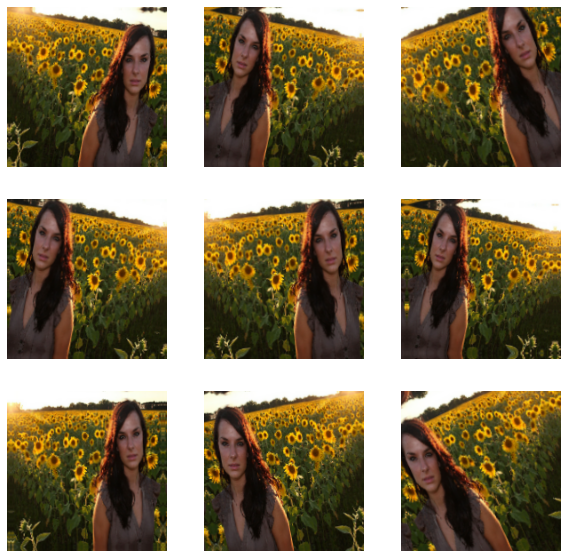

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 드롭아웃

과대적합을 줄이는 또 다른 기술은 네트워크에 [드롭아웃](https://developers.google.com/machine-learning/glossary#dropout_regularization) 정규화를 도입하는 것입니다.

드롭아웃을 레이어에 적용하면, 훈련 프로세스 중에 레이어에서 여러 출력 단위가 무작위로 드롭아웃됩니다(활성화를 0으로 설정). 드롭아웃은 0.1, 0.2, 0.4 등의 형식으로 소수를 입력 값으로 사용합니다. 이는 적용된 레이어에서 출력 단위의 10%, 20% 또는 40%를 임의로 제거하는 것을 의미합니다.

증강 이미지를 사용하여 훈련하기 전에 `tf.keras.layers.Dropout`을 사용하여 새로운 신경망을 생성해 보겠습니다.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

## 모델 컴파일 및 훈련하기

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 4s 42ms/step - loss: 0.5951 - accuracy: 0.7704 - val_loss: 0.6232 - val_accuracy: 0.7466
Epoch 2/20
92/92 [==============================] - 4s 41ms/step - loss: 0.5673 - accuracy: 0.7837 - val_loss: 0.6204 - val_accuracy: 0.7480
Epoch 3/20
92/92 [==============================] - 4s 42ms/step - loss: 0.5826 - accuracy: 0.7762 - val_loss: 0.6102 - val_accuracy: 0.7548
Epoch 4/20
92/92 [==============================] - 4s 42ms/step - loss: 0.5659 - accuracy: 0.7813 - val_loss: 0.6231 - val_accuracy: 0.7575
Epoch 5/20
92/92 [==============================] - 4s 41ms/step - loss: 0.5456 - accuracy: 0.7946 - val_loss: 0.6297 - val_accuracy: 0.7657
Epoch 6/20
92/92 [==============================] - 4s 42ms/step - loss: 0.5432 - accuracy: 0.7899 - val_loss: 0.6398 - val_accuracy: 0.7466
Epoch 7/20
92/92 [==============================] - 4s 42ms/step - loss: 0.5199 - accuracy: 0.7997 - val_loss: 0.6370 - val_accuracy: 0.7507
Epoch 8/20
92

## 훈련 결과 시각화하기

데이터 증강 및 `tf.keras.layers.Dropout` 적용 후 이전보다 과대적합이 적고 훈련 및 검증 정확도가 더 밀접하게 정렬됩니다.

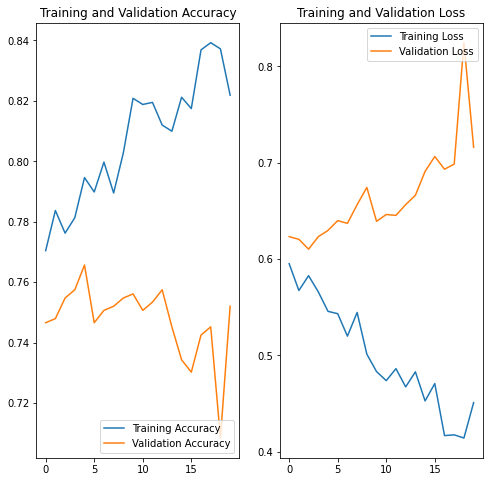

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 새로운 데이터로 예측하기

마지막으로, 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류해 보겠습니다.

In [ ]:

flower_path = "/content/datasets/flower_photos/sunflowers/15054865768_2cc87ac9d4_m.jpg"

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

print(img_array.shape)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

(1, 180, 180, 3)
1/1 [==============================] - 0s 70ms/step
[[ 6.0928264  1.3249676 -3.7855532  8.843479  -3.705492 ]]
This image most likely belongs to sunflowers with a 93.95 percent confidence.


1/1 [==============================] - 0s 16ms/step


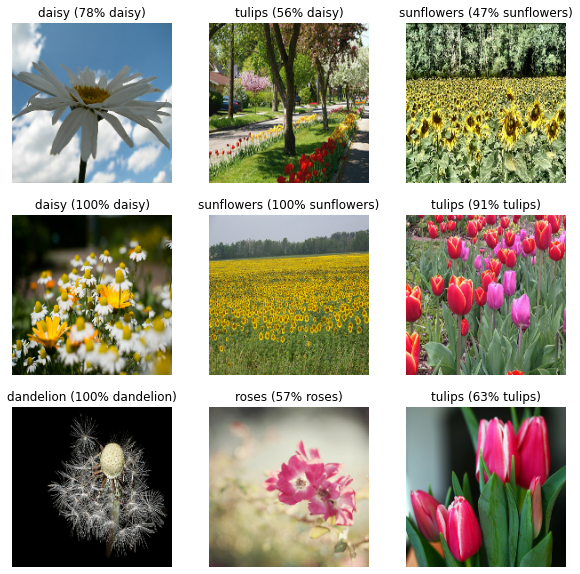

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predictions = model.predict(tf.expand_dims(images[i], 0))
    score = tf.nn.softmax(predictions[0])

    plt.title("{} ({:2.0f}% {})".format(class_names[labels[i]],
                                100*np.max(score),
                                class_names[np.argmax(score)]))
    plt.axis("off")